In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load the 50k sample for faster training
print("Loading preprocessed data...")
df = pd.read_csv('../data/processed/preprocessed_data_sample_50k.csv')

print(f"✅ Loaded {len(df):,} samples")
print(f"\nDataset info:")
print(f"  - Sarcastic: {df['label'].sum():,} ({df['label'].sum()/len(df)*100:.1f}%)")
print(f"  - Non-sarcastic: {(len(df) - df['label'].sum()):,} ({(1-df['label'].sum()/len(df))*100:.1f}%)")

print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Loading preprocessed data...
✅ Loaded 50,000 samples

Dataset info:
  - Sarcastic: 25,222 (50.4%)
  - Non-sarcastic: 24,778 (49.6%)

Columns: ['label', 'comment', 'cleaned_comment', 'tokens', 'cleaned_length']

First few rows:


,label,comment,cleaned_comment,tokens,cleaned_length
0,1,omg how phallic and interesting,omg how phallic and interesting,"['omg', 'how', 'phallic', 'and', 'interesting']",31
1,0,The problem is most Americans can't understand...,the problem is most americans can't understand...,"['the', 'problem', 'is', 'most', 'americans', ...",60
2,1,When we gonna start seeing the new doom on mob...,when we gonna start seeing the new doom on mobile,"['when', 'we', 'gon', 'na', 'start', 'seeing',...",49
3,0,"Yeah, but the pennies were used to fund the gu...",yeah but the pennies were used to fund the guy...,"['yeah', 'but', 'the', 'pennies', 'were', 'use...",90
4,0,"But they are all my family now, even this gree...",but they are all my family now even this green...,"['but', 'they', 'are', 'all', 'my', 'family', ...",52


In [3]:
# Prepare features (X) and labels (y)
X = df['cleaned_comment']  # Text data
y = df['label']            # 0 = Not Sarcastic, 1 = Sarcastic

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Ensures balanced split
)

print("✅ Data split complete!")
print(f"\nTraining set: {len(X_train):,} samples")
print(f"  - Sarcastic: {y_train.sum():,}")
print(f"  - Non-sarcastic: {len(y_train) - y_train.sum():,}")

print(f"\nTest set: {len(X_test):,} samples")
print(f"  - Sarcastic: {y_test.sum():,}")
print(f"  - Non-sarcastic: {len(y_test) - y_test.sum():,}")

print(f"\nSample training texts:")
for i in range(3):
    label = "SARCASTIC" if y_train.iloc[i] == 1 else "NOT SARCASTIC"
    print(f"{i+1}. [{label}] {X_train.iloc[i][:80]}...")

✅ Data split complete!

Training set: 40,000 samples
  - Sarcastic: 20,178
  - Non-sarcastic: 19,822

Test set: 10,000 samples
  - Sarcastic: 5,044
  - Non-sarcastic: 4,956

Sample training texts:
1. [SARCASTIC] home run bats in splatoon...
2. [NOT SARCASTIC] queue at the same time make sure you get your match accept decline buttons at th...
3. [NOT SARCASTIC] bad religion american jesus...


In [4]:
# Create TF-IDF vectorizer
print("Creating TF-IDF features...")
print("This may take 1-2 minutes...\n")

tfidf = TfidfVectorizer(
    max_features=5000,      # Keep top 5000 most important words
    min_df=5,               # Word must appear in at least 5 documents
    max_df=0.7,             # Ignore words that appear in >70% of documents
    ngram_range=(1, 2),     # Use single words and word pairs
    strip_accents='unicode',
    lowercase=True,
    token_pattern=r'\w{3,}' # Only words with 3+ characters
)

# Fit on training data and transform both train and test
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("✅ TF-IDF transformation complete!")
print(f"\nFeature matrix shape:")
print(f"  - Training: {X_train_tfidf.shape}")
print(f"  - Testing: {X_test_tfidf.shape}")
print(f"\nTotal features (words/bigrams): {len(tfidf.get_feature_names_out()):,}")

# Show top features
print(f"\nTop 20 features by importance:")
feature_names = tfidf.get_feature_names_out()
for i, word in enumerate(feature_names[:20], 1):
    print(f"{i:2}. {word}")

Creating TF-IDF features...
This may take 1-2 minutes...

✅ TF-IDF transformation complete!

Feature matrix shape:
  - Training: (40000, 5000)
  - Testing: (10000, 5000)

Total features (words/bigrams): 5,000

Top 20 features by importance:
 1. ability
 2. able
 3. able get
 4. about
 5. about all
 6. about and
 7. about being
 8. about his
 9. about how
10. about that
11. about the
12. about their
13. about this
14. about what
15. about you
16. about your
17. above
18. absolute
19. absolutely
20. abuse


In [5]:
# Train Logistic Regression model
print("Training Logistic Regression model...")
print("This may take 2-3 minutes...\n")

# Create model
lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    n_jobs=-1  # Use all CPU cores for faster training
)

# Train the model
lr_model.fit(X_train_tfidf, y_train)

print("✅ Model training complete!")

# Make predictions on test set
print("\nMaking predictions on test set...")
y_pred = lr_model.predict(X_test_tfidf)
y_pred_proba = lr_model.predict_proba(X_test_tfidf)[:, 1]  # Probability of sarcasm

print("✅ Predictions complete!")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n{'='*60}")
print(f"MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"{'='*60}")

Training Logistic Regression model...
This may take 2-3 minutes...

✅ Model training complete!

Making predictions on test set...
✅ Predictions complete!

MODEL PERFORMANCE
Test Accuracy: 66.41%


CLASSIFICATION REPORT
               precision    recall  f1-score   support

Not Sarcastic       0.65      0.70      0.67      4956
    Sarcastic       0.68      0.63      0.65      5044

     accuracy                           0.66     10000
    macro avg       0.67      0.66      0.66     10000
 weighted avg       0.67      0.66      0.66     10000


CONFUSION MATRIX

[[3460 1496]
 [1863 3181]]

True Negatives (Correctly identified as NOT sarcastic): 3,460
False Positives (Wrongly identified as sarcastic): 1,496
False Negatives (Missed sarcasm): 1,863
True Positives (Correctly identified as sarcastic): 3,181


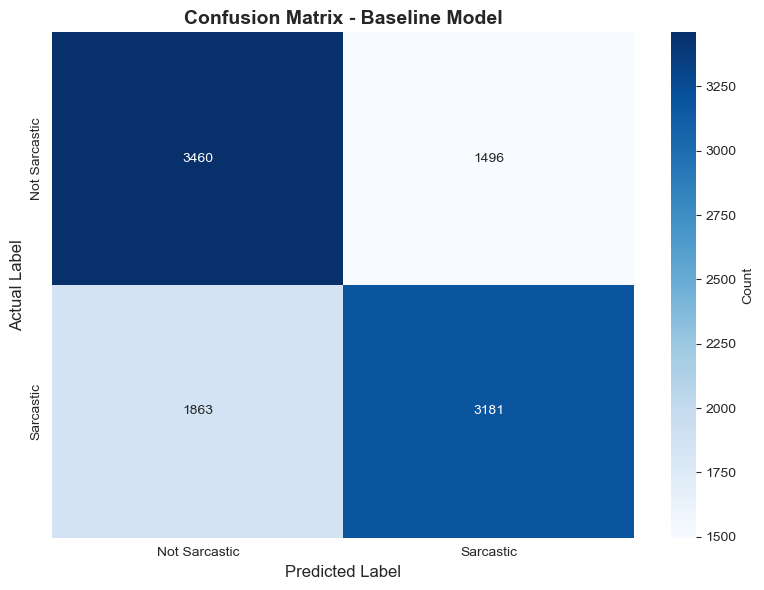


SARCASM DETECTION PERFORMANCE
Precision: 68.01% (Of predicted sarcasm, how many were correct)
Recall: 63.07% (Of actual sarcasm, how many did we catch)
F1-Score: 65.45% (Harmonic mean of precision & recall)


In [6]:
# Detailed classification metrics
print("="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, 
                          target_names=['Not Sarcastic', 'Sarcastic']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)
print(f"\n{cm}\n")

# Calculate metrics manually for clarity
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives (Correctly identified as NOT sarcastic): {tn:,}")
print(f"False Positives (Wrongly identified as sarcastic): {fp:,}")
print(f"False Negatives (Missed sarcasm): {fn:,}")
print(f"True Positives (Correctly identified as sarcastic): {tp:,}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Baseline Model', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate additional metrics
precision_sarcastic = tp / (tp + fp)
recall_sarcastic = tp / (tp + fn)
f1_sarcastic = 2 * (precision_sarcastic * recall_sarcastic) / (precision_sarcastic + recall_sarcastic)

print(f"\n{'='*60}")
print("SARCASM DETECTION PERFORMANCE")
print(f"{'='*60}")
print(f"Precision: {precision_sarcastic*100:.2f}% (Of predicted sarcasm, how many were correct)")
print(f"Recall: {recall_sarcastic*100:.2f}% (Of actual sarcasm, how many did we catch)")
print(f"F1-Score: {f1_sarcastic*100:.2f}% (Harmonic mean of precision & recall)")

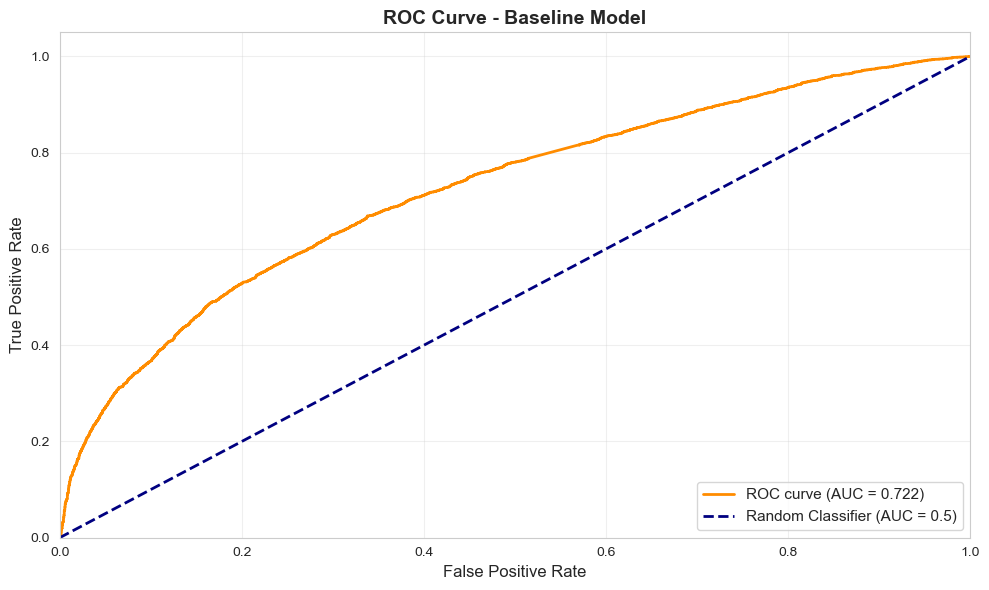

ROC-AUC Score: 0.7225

Interpretation:
  - AUC = 0.5: Random guessing
  - AUC = 1.0: Perfect classifier
  - Our AUC = 0.722: Good


In [7]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Baseline Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"{'='*60}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"{'='*60}")
print(f"\nInterpretation:")
print(f"  - AUC = 0.5: Random guessing")
print(f"  - AUC = 1.0: Perfect classifier")
print(f"  - Our AUC = {roc_auc:.3f}: {'Good' if roc_auc > 0.7 else 'Decent baseline'}")

In [8]:
# Create results dataframe
results_df = pd.DataFrame({
    'text': X_test.values,
    'actual': y_test.values,
    'predicted': y_pred,
    'probability': y_pred_proba
})

# Identify correct and incorrect predictions
results_df['correct'] = results_df['actual'] == results_df['predicted']

# Calculate error counts
total_errors = (~results_df['correct']).sum()
total_correct = results_df['correct'].sum()

print("="*80)
print("ERROR ANALYSIS")
print("="*80)
print(f"\nTotal predictions: {len(results_df):,}")
print(f"Correct predictions: {total_correct:,} ({total_correct/len(results_df)*100:.2f}%)")
print(f"Incorrect predictions: {total_errors:,} ({total_errors/len(results_df)*100:.2f}%)")

# False Positives: Predicted sarcastic but actually not
false_positives = results_df[(results_df['actual'] == 0) & (results_df['predicted'] == 1)]
print(f"\n{'='*80}")
print(f"FALSE POSITIVES: Wrongly classified as SARCASTIC")
print(f"{'='*80}")
print(f"Count: {len(false_positives):,}\n")
print("Examples (High confidence mistakes):")
for i, row in false_positives.nlargest(5, 'probability').iterrows():
    print(f"\n{i+1}. Text: {row['text'][:100]}...")
    print(f"   Confidence: {row['probability']*100:.1f}% sarcastic")
    print(f"   Actual: NOT sarcastic")

# False Negatives: Predicted not sarcastic but actually sarcastic
false_negatives = results_df[(results_df['actual'] == 1) & (results_df['predicted'] == 0)]
print(f"\n{'='*80}")
print(f"FALSE NEGATIVES: Missed SARCASM")
print(f"{'='*80}")
print(f"Count: {len(false_negatives):,}\n")
print("Examples (High confidence mistakes):")
for i, row in false_negatives.nsmallest(5, 'probability').iterrows():
    print(f"\n{i+1}. Text: {row['text'][:100]}...")
    print(f"   Confidence: {(1-row['probability'])*100:.1f}% NOT sarcastic")
    print(f"   Actual: Sarcastic")

# Correctly identified sarcasm (for comparison)
true_positives = results_df[(results_df['actual'] == 1) & (results_df['predicted'] == 1)]
print(f"\n{'='*80}")
print(f"CORRECTLY DETECTED SARCASM (Examples)")
print(f"{'='*80}")
for i, row in true_positives.nlargest(5, 'probability').iterrows():
    print(f"\n{i+1}. Text: {row['text'][:100]}...")
    print(f"   Confidence: {row['probability']*100:.1f}% sarcastic ✅")

ERROR ANALYSIS

Total predictions: 10,000
Correct predictions: 6,641 (66.41%)
Incorrect predictions: 3,359 (33.59%)

FALSE POSITIVES: Wrongly classified as SARCASTIC
Count: 1,496

Examples (High confidence mistakes):

6656. Text: clearly an engineer...
   Confidence: 98.9% sarcastic
   Actual: NOT sarcastic

5839. Text: you're totally right...
   Confidence: 98.3% sarcastic
   Actual: NOT sarcastic

195. Text: oh yeah...
   Confidence: 97.3% sarcastic
   Actual: NOT sarcastic

1233. Text: heeelllll yeah...
   Confidence: 97.3% sarcastic
   Actual: NOT sarcastic

2264. Text: yeah cheers...
   Confidence: 97.3% sarcastic
   Actual: NOT sarcastic

FALSE NEGATIVES: Missed SARCASM
Count: 1,863

Examples (High confidence mistakes):

6232. Text: i also say pepper and salt...
   Confidence: 94.2% NOT sarcastic
   Actual: Sarcastic

9190. Text: gainesville is my favorite part of atlanta...
   Confidence: 92.6% NOT sarcastic
   Actual: Sarcastic

2806. Text: martin luther king day is a school ho

In [9]:
import os
import pickle

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the trained model
model_path = '../models/baseline_logistic_regression.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(lr_model, f)
print(f"✅ Model saved to: {model_path}")

# Save the TF-IDF vectorizer (needed for predictions on new data)
vectorizer_path = '../models/tfidf_vectorizer.pkl'
with open(vectorizer_path, 'wb') as f:
    pickle.dump(tfidf, f)
print(f"✅ Vectorizer saved to: {vectorizer_path}")

# Save results dataframe for later analysis
results_path = '../results/baseline_predictions.csv'
os.makedirs('../results', exist_ok=True)
results_df.to_csv(results_path, index=False)
print(f"✅ Predictions saved to: {results_path}")

print("\n" + "="*60)
print("All model artifacts saved successfully!")
print("="*60)

✅ Model saved to: ../models/baseline_logistic_regression.pkl
✅ Vectorizer saved to: ../models/tfidf_vectorizer.pkl
✅ Predictions saved to: ../results/baseline_predictions.csv

All model artifacts saved successfully!


BASELINE MODEL - FINAL SUMMARY

📊 MODEL SPECIFICATIONS:
  • Algorithm: Logistic Regression
  • Features: TF-IDF (max 5,000 features)
  • N-grams: Unigrams + Bigrams (1-2 words)
  • Training samples: 40,000
  • Test samples: 10,000

🎯 PERFORMANCE METRICS:
  • Overall Accuracy: 66.41%
  • ROC-AUC Score: 0.7225
  • Precision (Sarcasm): 68.01%
  • Recall (Sarcasm): 63.07%
  • F1-Score (Sarcasm): 65.45%

❌ ERROR BREAKDOWN:
  • False Positives: 1,496 (wrongly flagged as sarcastic)
  • False Negatives: 1,863 (missed actual sarcasm)
  • Total Errors: 3,359 out of 10,000

💡 KEY INSIGHTS:
  • The model achieves 66.4% accuracy with simple features
  • TF-IDF captures some word patterns but misses context
  • Sarcasm often requires understanding tone, not just words
  • Simple baseline provides good starting point for comparison

📈 WHAT'S NEXT:
  1. Try with full dataset (1M samples) instead of 50k
  2. Add more features (punctuation, capitalization, emojis)
  3. Implement LSTM for sequential cont

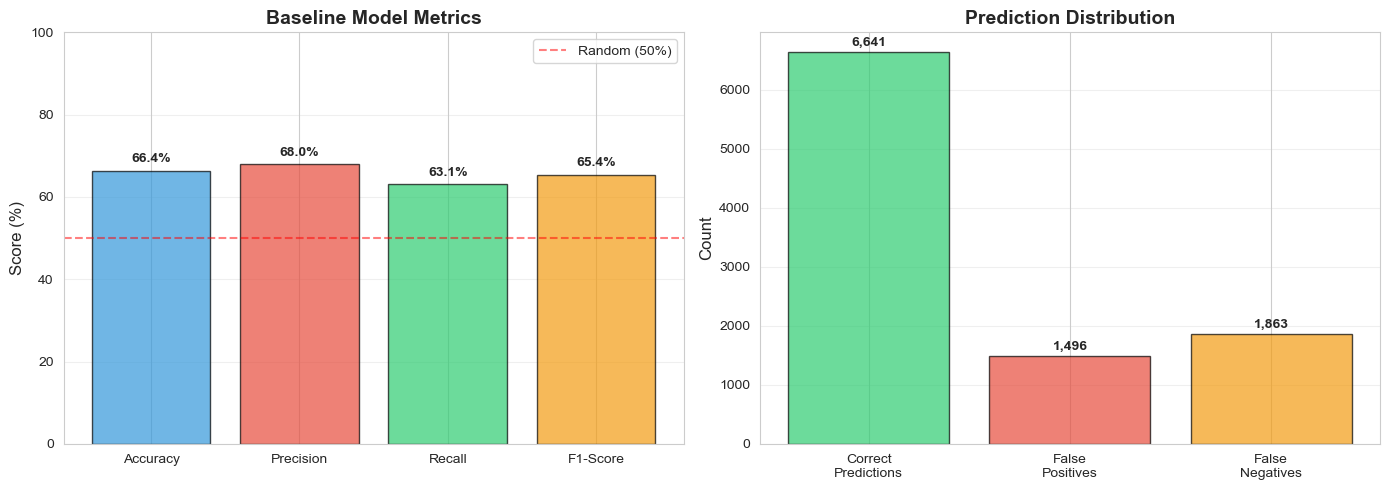


📊 Summary visualization saved to: results/baseline_model_summary.png


In [10]:
print("="*80)
print("BASELINE MODEL - FINAL SUMMARY")
print("="*80)

print("\n📊 MODEL SPECIFICATIONS:")
print(f"  • Algorithm: Logistic Regression")
print(f"  • Features: TF-IDF (max 5,000 features)")
print(f"  • N-grams: Unigrams + Bigrams (1-2 words)")
print(f"  • Training samples: {len(X_train):,}")
print(f"  • Test samples: {len(X_test):,}")

print("\n🎯 PERFORMANCE METRICS:")
print(f"  • Overall Accuracy: {accuracy*100:.2f}%")
print(f"  • ROC-AUC Score: {roc_auc:.4f}")
print(f"  • Precision (Sarcasm): {precision_sarcastic*100:.2f}%")
print(f"  • Recall (Sarcasm): {recall_sarcastic*100:.2f}%")
print(f"  • F1-Score (Sarcasm): {f1_sarcastic*100:.2f}%")

print("\n❌ ERROR BREAKDOWN:")
print(f"  • False Positives: {len(false_positives):,} (wrongly flagged as sarcastic)")
print(f"  • False Negatives: {len(false_negatives):,} (missed actual sarcasm)")
print(f"  • Total Errors: {total_errors:,} out of {len(results_df):,}")

print("\n💡 KEY INSIGHTS:")
print(f"  • The model achieves {accuracy*100:.1f}% accuracy with simple features")
print(f"  • TF-IDF captures some word patterns but misses context")
print(f"  • Sarcasm often requires understanding tone, not just words")
print(f"  • Simple baseline provides good starting point for comparison")

print("\n📈 WHAT'S NEXT:")
print(f"  1. Try with full dataset (1M samples) instead of 50k")
print(f"  2. Add more features (punctuation, capitalization, emojis)")
print(f"  3. Implement LSTM for sequential context")
print(f"  4. Fine-tune BERT for better contextual understanding")
print(f"  5. Expected improvement: 75-85% with deep learning")

print("\n📁 SAVED FILES:")
print(f"  • Model: models/baseline_logistic_regression.pkl")
print(f"  • Vectorizer: models/tfidf_vectorizer.pkl")
print(f"  • Predictions: results/baseline_predictions.csv")

print("\n✅ BASELINE MODEL COMPLETE!")
print("="*80)

# Create a quick visualization of performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [accuracy*100, precision_sarcastic*100, recall_sarcastic*100, f1_sarcastic*100]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

axes[0].bar(metrics, scores, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Score (%)', fontsize=12)
axes[0].set_title('Baseline Model Metrics', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 100)
axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Random (50%)')
for i, v in enumerate(scores):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Error distribution
error_types = ['Correct\nPredictions', 'False\nPositives', 'False\nNegatives']
error_counts = [total_correct, len(false_positives), len(false_negatives)]
error_colors = ['#2ecc71', '#e74c3c', '#f39c12']

axes[1].bar(error_types, error_counts, color=error_colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Prediction Distribution', fontsize=14, fontweight='bold')
for i, v in enumerate(error_counts):
    axes[1].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/baseline_model_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Summary visualization saved to: results/baseline_model_summary.png")